# FRA 503: Deep Reinforcement Learning
# Homework 1

## Part 1: Setting up Multi-armed Bandit.

In [29]:
import numpy as np
import matplotlib.pyplot as plt

#### Bandit Class 
1. ฟังชั่นตั้งต้นจะกำหนด
    - จำนวน Bandits
    - hidden reward distributions สำหรับแต่ละ bandit (0-1 แทนโอกาสได้รางวัล 0-100%) 
2.  ฟังชั่น get_reward 
    - รับ bandit_index เพื่อระบุ Bandit ที่ถูกเลือก
    - สุ่มค่าโดยอิงตาม rate ที่กำหนดใน hidden reward distributions ถ้าถูกรางวัลจะ return 1 ไม่ถูกจะ return 0

In [46]:
import numpy as np

class Bandit:
    def __init__(self, n_bandits, custom_rewards=None):
        # จำนวน Bandits
        self.n_bandits = n_bandits

        if custom_rewards is None:
            # สร้าง hidden reward distributions สำหรับแต่ละ bandit (สุ่มค่าความน่าจะเป็นระหว่าง 0 ถึง 1)
            self.reward_distributions = np.random.uniform(0, 1, self.n_bandits)
        else:
            # print(len(custom_rewards),n_bandits)
            if len(custom_rewards) == n_bandits:
                # ใช้ custom rewards ที่ผู้ใช้ให้มา
                self.reward_distributions = np.array(custom_rewards)
            else:
                raise ValueError("Custom rewards must be an array of length equal to n_bandits.")

    def get_reward(self, bandit_index):
        if 0 <= bandit_index < self.n_bandits:
            # สุ่มรางวัล: 1 (ถูกรางวัล) หรือ 0 (ไม่ถูกรางวัล) ตามความน่าจะเป็น
            return 1 if np.random.rand() < self.reward_distributions[bandit_index] else 0
        else:
            raise ValueError("Bandit index out of range!")



#### Agent Class 
1. ฟังชั่นตั้งต้นจะกำหนด
    - จำนวน Bandits
    - Learning Rate
    - Q-value
    - ค่าคงที่สำหรับ UCB
    - จำนวน timestep ทั้งหมด
    - action_probs ความน่าจะเป็นในการเลือกครั้งแรกจะเท่ากันทุก  bandit


2. ฟังชั่น select_action ใช้ในการเลือก bandits โดยตั้งต้นจะให้ใช้ UCB 
    - Upper Confidence Bound (UCB)
        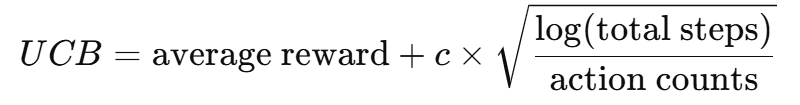


3. ฟังชั่น update




In [31]:
class Agent:
    def __init__(self, n_bandits ,c =2 , epsilon = 0.5):
        #จำนวน bandits
        self.n_bandits = n_bandits 
        # เริ่มต้นค่าประมาณการรางวัล (Q-value) และ policy (action distribution)
        self.q_values = np.zeros(n_bandits) 
        
        #Upper Confidence Bound (UCB)
        self.c = c  # ค่าคงที่สำหรับ UCB  
        self.total_steps = 0  # จำนวน timestep ทั้งหมด
        self.action_counts = np.zeros(n_bandits)  # จำนวนครั้งที่เลือกแต่ละ Bandit
        
        #Epsilon-Greedy
        self.epsilon = epsilon  # ค่า Epsilon สำหรับ Epsilon-Greedy
    
    def select_action_UCB(self):
        """
        เลือก Bandit โดยใช้อัลกอริทึม Upper Confidence Bound (UCB)
        :return: ดัชนีของ Bandit ที่เลือก
        """
        self.total_steps += 1
        ucb_values = np.zeros(self.n_bandits)
        
        for i in range(self.n_bandits):
            if self.action_counts[i] > 0:
                # ปรับสูตรความมั่นใจ (เพิ่ม +1 ในตัวหารเพื่อป้องกันหารด้วย 0)
                confidence = self.c * np.sqrt(np.log(self.total_steps) / (self.action_counts[i] + 1))
                ucb_values[i] = self.q_values[i] + confidence
            else:
                # เลือก Bandit ที่ยังไม่เคยถูกเลือก
                return i
        
        # เลือก Bandit ที่มีค่า UCB สูงสุด
        return np.argmax(ucb_values)
    
    def select_action_epsilon_greedy(self):
        """
        เลือก Bandit โดยใช้อัลกอริทึม Epsilon-Greedy
        :return: ดัชนีของ Bandit ที่เลือก
        """
        self.total_steps += 1

        if np.random.rand() < self.epsilon:
            # Exploration: เลือก Bandit แบบสุ่ม
            return np.random.randint(0, self.n_bandits)
        else:
            # Exploitation: เลือก Bandit ที่มีค่า Q-value สูงสุด
            return np.argmax(self.q_values)
        
    
    def update(self, action, reward):
        """
        อัปเดต Q-value และจำนวนครั้งที่เลือก Bandit
        :param action: ดัชนีของ Bandit ที่เลือก
        :param reward: รางวัลที่ได้รับจาก Bandit นั้น
        """
        self.action_counts[action] += 1
        # อัปเดต Q-value แบบ incremental
        self.q_values[action] += (reward - self.q_values[action]) / self.action_counts[action]

In [47]:
def run_experiment(n_bandits, n_steps, c=2, epsilon=0.5, method="UCB",custom_rewards=None):
    # print(f"custom_rewards at start: {custom_rewards}")  # Debug print
    bandit = Bandit(n_bandits,custom_rewards)
    agent = Agent(n_bandits, c, epsilon)

    rewards = []
    cumulative_rewards = []

    for step in range(n_steps):
        # เลือกฟังก์ชันการเลือก Bandit ตาม method ที่กำหนด
        if method == "UCB":
            action = agent.select_action_UCB()
        elif method == "Epsilon-Greedy":
            action = agent.select_action_epsilon_greedy()
        else:
            raise ValueError("Invalid method. Choose 'UCB' or 'Epsilon-Greedy'.")

        # รับรางวัลจาก Bandit
        reward = bandit.get_reward(action)

        # อัปเดต Q-value และจำนวนครั้งที่เลือก
        agent.update(action, reward)

        # เก็บรางวัลและคำนวณรางวัลสะสมเฉลี่ย
        rewards.append(reward)
        cumulative_rewards.append(np.mean(rewards))

    return rewards, cumulative_rewards, bandit.reward_distributions


## Generate a random reward and see how algorithm act.

#### First, we will use a UCB Algorithm and set a n_bandits to 5, n_steps = 1000, c = 1. 

Hidden reward distributions: [0.5848687  0.8967036  0.78503461 0.64135918 0.1924235 ]
Maximum Possible Reward : 0.8967036031136311
Average reward after 1000 steps using UCB: 0.85


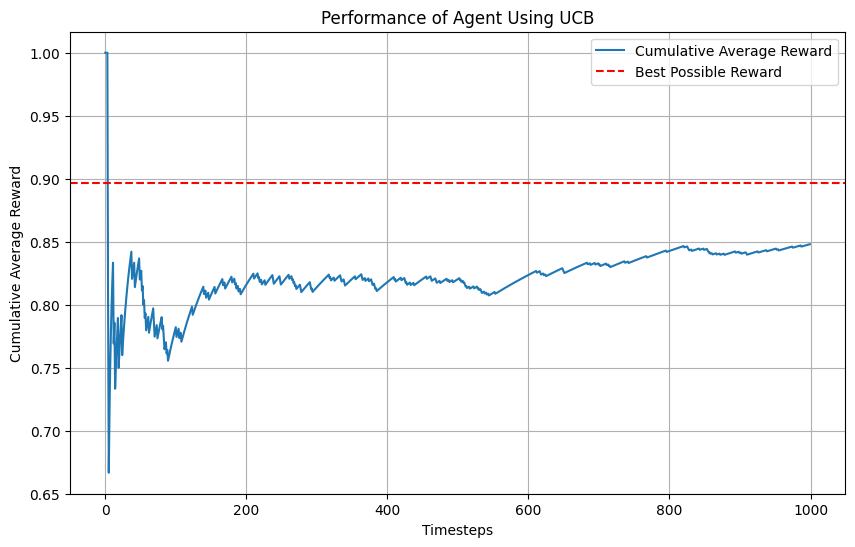

In [24]:
if __name__ == "__main__":
    n_bandits = 5     # จำนวน Bandits
    n_steps = 1000    # จำนวน Timestep
    c = 1             # ค่า UCB ค่าคงที่สำหรับ Exploration
    epsilon = 0.1     # ค่า Epsilon สำหรับ Epsilon-Greedy
    rewards = None    # make it random

    # เลือกวิธีการทดลอง
    method ="UCB"

    # รันการทดลอง
    rewards, cumulative_rewards, hidden_rewards = run_experiment(
        n_bandits=n_bandits,
        n_steps=n_steps,
        c=c,
        epsilon=epsilon,
        method=method,
        custom_rewards=rewards
    )

    # แสดงผลลัพธ์ใน console
    print(f"Hidden reward distributions: {hidden_rewards}")
    print(f"Maximum Possible Reward : {max(hidden_rewards)}")
    print(f"Average reward after {n_steps} steps using {method}: {np.mean(rewards):.2f}")

    # แสดงกราฟ
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards, label="Cumulative Average Reward")
    plt.axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    plt.title(f"Performance of Agent Using {method}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Average Reward")
    plt.legend()
    plt.grid()
    plt.show()


#### Then, we will set a n_bandits to 10. 

Hidden reward distributions: [0.66130328 0.49565106 0.12599027 0.57715621 0.16537129 0.50897837
 0.9784453  0.77645298 0.66083997 0.98377325]
Maximum Possible Reward : 0.9837732480844471
Average reward after 1000 steps using UCB: 0.90


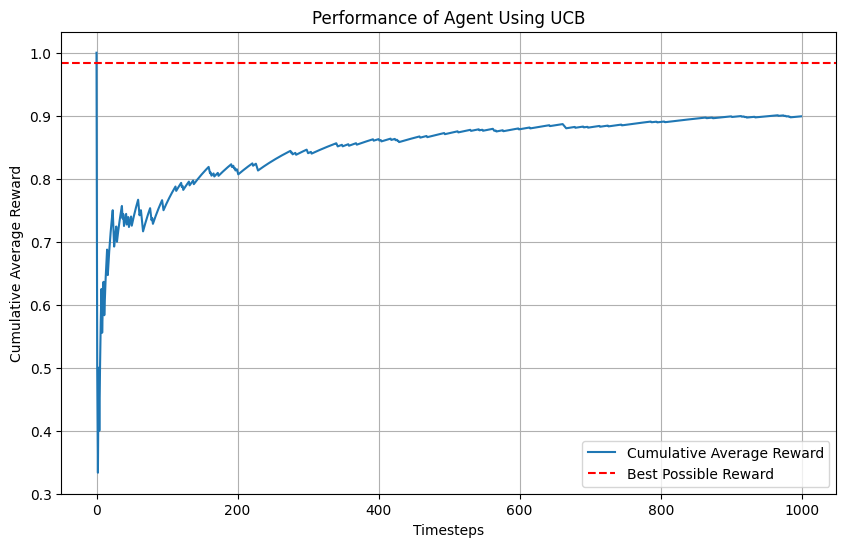

In [33]:
if __name__ == "__main__":
    n_bandits = 10     # จำนวน Bandits
    n_steps = 1000    # จำนวน Timestep
    c = 1             # ค่า UCB ค่าคงที่สำหรับ Exploration
    epsilon = 0.1     # ค่า Epsilon สำหรับ Epsilon-Greedy
    rewards = None    # make it random

    # เลือกวิธีการทดลอง
    method ="UCB"

    # รันการทดลอง
    rewards, cumulative_rewards, hidden_rewards = run_experiment(
        n_bandits=n_bandits,
        n_steps=n_steps,
        c=c,
        epsilon=epsilon,
        method=method,
        custom_rewards=rewards
    )

    # แสดงผลลัพธ์ใน console
    print(f"Hidden reward distributions: {hidden_rewards}")
    print(f"Maximum Possible Reward : {max(hidden_rewards)}")
    print(f"Average reward after {n_steps} steps using {method}: {np.mean(rewards):.2f}")

    # แสดงกราฟ
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards, label="Cumulative Average Reward")
    plt.axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    plt.title(f"Performance of Agent Using {method}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Average Reward")
    plt.legend()
    plt.grid()
    plt.show()


## Part 3: Implementing UCB

c = 0.1: Average reward = 0.50
c = 0.5: Average reward = 0.49
c = 1: Average reward = 0.49
c = 2: Average reward = 0.43
c = 5: Average reward = 0.34
Hidden reward distributions: [0.1  0.2  0.15 0.5  0.3 ]


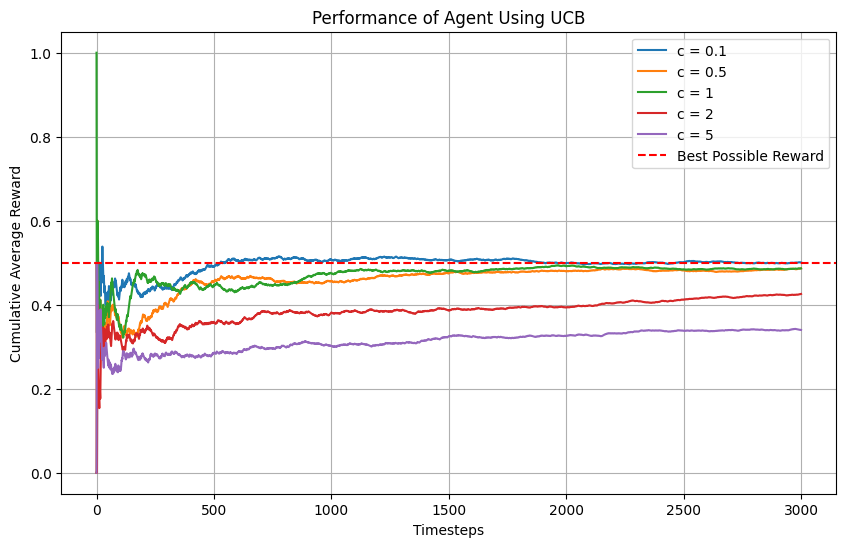

In [52]:
if __name__ == "__main__":
    cumulative_rewards_results = {}

    n_bandits = 5     # จำนวน Bandits
    n_steps = 3000    # จำนวน Timestep
    c_values = [0.1, 0.5, 1, 2, 5]
    rewards = [0.1, 0.2, 0.15, 0.5, 0.3]

    # เลือกวิธีการทดลอง
    method = "UCB"
    
    for c in c_values:
        # รันการทดลอง
        rewards = [0.1, 0.2, 0.15, 0.5, 0.3]
        custom_rewards = rewards.copy()  # Creates a separate list
        rewards, cumulative_rewards, hidden_rewards = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, c=c, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results[c] = cumulative_rewards

        print(f"c = {c}: Average reward = {np.mean(rewards):.2f}")

    # แสดงผลลัพธ์ใน console
    print(f"Hidden reward distributions: {hidden_rewards}")
    # print(f"Average reward after {n_steps} steps using {method}: {np.mean(rewards):.2f}")

    # แสดงกราฟ
    plt.figure(figsize=(10, 6))
    for c, cumulative_rewards in cumulative_rewards_results.items():
        plt.plot(cumulative_rewards, label=f"c = {c}")
    plt.axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    plt.title(f"Performance of Agent Using {method}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Average Reward")
    plt.legend()
    plt.grid()
    plt.show()


## Part 2: Implementing epsilon-greedy algorithm.

epsilon = 0.1: Average reward = 0.45
epsilon = 0.5: Average reward = 0.37
epsilon = 1: Average reward = 0.25
epsilon = 2: Average reward = 0.25
epsilon = 5: Average reward = 0.26
Hidden reward distributions: [0.1  0.2  0.15 0.5  0.3 ]


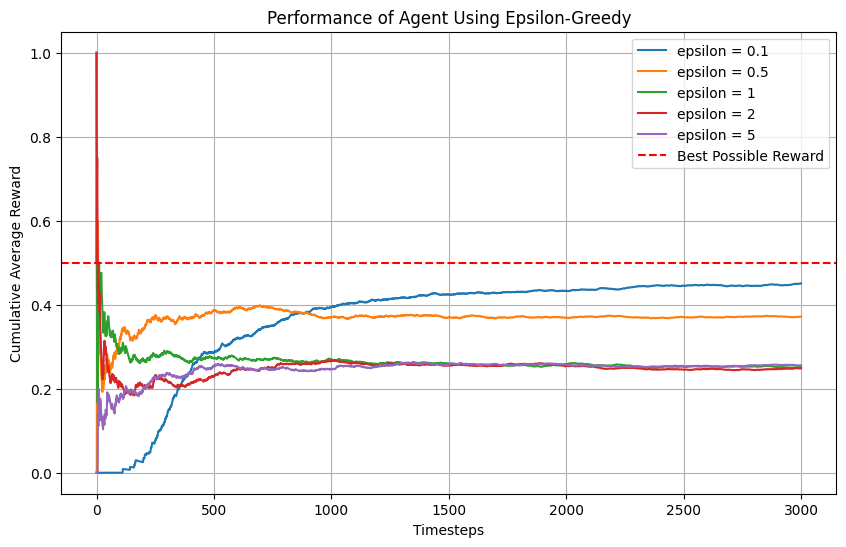

In [54]:
if __name__ == "__main__":
    cumulative_rewards_results = {}

    n_bandits = 5     # จำนวน Bandits
    n_steps = 3000    # จำนวน Timestep
    epsilon_values = [0.1, 0.5, 1, 2, 5]
    rewards = [0.1, 0.2, 0.15, 0.5, 0.3]

    # เลือกวิธีการทดลอง
    method = "Epsilon-Greedy"  

    for epsilon in epsilon_values:
        # รันการทดลอง
        rewards = [0.1, 0.2, 0.15, 0.5, 0.3]
        custom_rewards = rewards.copy()  # Creates a separate list
        rewards, cumulative_rewards, hidden_rewards = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps,epsilon=epsilon, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results[epsilon] = cumulative_rewards

        print(f"epsilon = {epsilon}: Average reward = {np.mean(rewards):.2f}")

    # แสดงผลลัพธ์ใน console
    print(f"Hidden reward distributions: {hidden_rewards}")
    # print(f"Average reward after {n_steps} steps using {method}: {np.mean(rewards):.2f}")

    # แสดงกราฟ
    plt.figure(figsize=(10, 6))
    for epsilon, cumulative_rewards in cumulative_rewards_results.items():
        plt.plot(cumulative_rewards, label=f"epsilon = {epsilon}")
    plt.axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    plt.title(f"Performance of Agent Using {method}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Average Reward")
    plt.legend()
    plt.grid()
    plt.show()
